# Single LSTM optimization
The performance of gradient boosting decision tree and deep neural net models on wildfire risk prediction is underwhelming. The poor performance of these model types may result form their inability to learn from the temporal order of the data. Once can imagine that the weather conditions leading up to a fire are significant causal factor in that fire. Long short term memory (LSTM) neural networks are designed for time series prediction and may perform better on wildfire risk prediction.

### Goal: 
Optimize and test the performance of a LSTM neural network on one California geospatial bin.

### Plan:
1. Prep data from one geospatial bin for input into LSTM
2. Generate 'Cassandra' model -> attempt to over fit and 'memorize' the training data. This will prove that the data is feature rich enough and a LSTM is complex enough to learn a function which successfully maps input to output.
3. If step 2 is successful, regularize model to increase generalizability.
4. Scale model to predict wilfire risk for all 410 California geospatial bins.

# Notebook setup

In [1]:
import os

import logging
import tensorflow as tf

# Note: tf 2.1.0 give warning about model weight format when
# using class weights. This is the only way to silence without
# updating
tf.get_logger().setLevel(logging.ERROR)
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
import joblib

from tensorflow import keras
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras import backend as K
from tensorflow.python.client import device_lib

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

In [2]:
# Note: sklearn forces depreciation warnings
# This is the only way to silence them without updating
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix

from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_objective, plot_evaluations
from skopt import gp_minimize

In [3]:
import helper_functions.plotting_functions as plotting_functions
import helper_functions.data_functions as data_functions
import helper_functions.config as config

In [4]:
print(f"Python {sys.version}")
print()
print(f"Pandas {pd.__version__}")
print(f"Tensorflow {tf.__version__}")
print(f"Keras {keras.__version__}")
print(f"SciKit Learn {sklearn.__version__}")
print()

devices = device_lib.list_local_devices()

if 'GPU' in ('').join(str(devices)):
    print("tf accessable GPU found: "+devices[-2].physical_device_desc)

Python 3.7.7 (default, Mar 23 2020, 22:36:06) 
[GCC 7.3.0]

Pandas 1.0.3
Tensorflow 2.2.0
Keras 2.3.0-tf
SciKit Learn 0.23.1

tf accessable GPU found: device: 0, name: GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1


# 1. Data preparation

Let's first load up the data and take a look at what we are working with.

In [5]:
# Load data
data_file = '/mnt/SSD/data/training_data/1992-2015_california_standard_scaled_mean_range_onehot_month_selective_box_cox.parquet'
raw_data = pd.read_parquet(data_file)

# Pick one spatial bin with fires
data = raw_data[(raw_data['raw_lat'] == 39.42233) & (raw_data['raw_lon'] == -120.6546)]

num_fires = data['ignition'].sum()
total_observations = len(data)

print("Num fires: "+str(num_fires))
print("Total obervations: "+str(total_observations))

# Also drop lat, lon, columns (unnecessary)
data.drop(['lat', 'lon', 'raw_lat', 'raw_lon'], axis=1, inplace=True)

data.reset_index(inplace=True, drop=True)
data.info()

Num fires: 377
Total obervations: 8766
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8766 entries, 0 to 8765
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   apcp               8766 non-null   float32       
 1   crain              8766 non-null   int32         
 2   veg                8766 non-null   float32       
 3   ignition           8766 non-null   int32         
 4   mean_air_2m        8766 non-null   float32       
 5   mean_rhum_2m       8766 non-null   float32       
 6   mean_dpt_2m        8766 non-null   float32       
 7   mean_pres_sfc      8766 non-null   float32       
 8   mean_uwnd_10m      8766 non-null   float32       
 9   mean_vwnd_10m      8766 non-null   float32       
 10  mean_vis           8766 non-null   float32       
 11  mean_cloud_cover   8766 non-null   float32       
 12  total_fires        8766 non-null   float32       
 13  date               8766 

Let's take a look at one of our weather variables and ignition. This way after we do our transformations we can be sure by comparison that we did not deform the data.

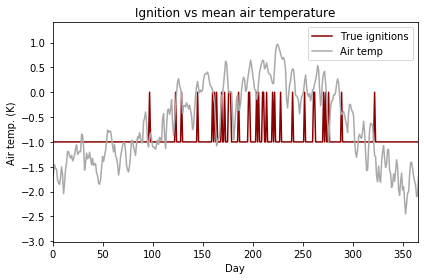

In [6]:
plotting_functions.data_diagnostic_plot(data, 'mean_air_2m', 1, -1)

Looks good, qualitatively, fire season is in late summer and early fall when temperatures are higher.

### Split data into training, validation and testing sets
Note: since temporal order matters here, we cannot simply randomly sample the data - we need to preserve the order. One possible improvement could be to break the data into many smaller ordered chunks and then sample those randomly...

In [7]:
# Split data up into training, testing and validation sets
test_data = data.tail(int(len(data)*0.25))
leftover_data = data.head(int(len(data)*0.75))
validation_data = data.tail(int(len(leftover_data)*0.5))
training_data = data.head(int(len(leftover_data)*0.5))

Let's compare the distributions of each weather variable across the train, validation and test sets just to be sure that our samples are matched to a first approximation.

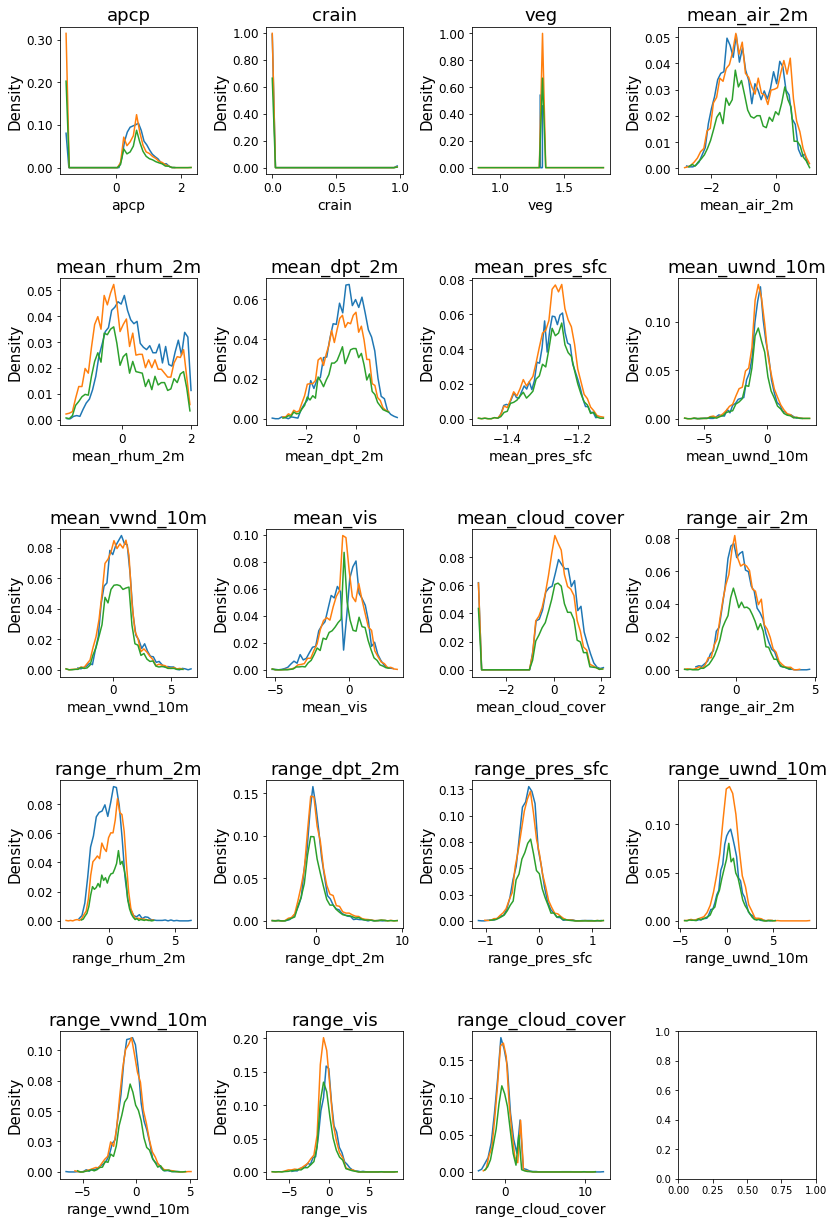

In [8]:
# plot split data distributions
features = [
    'apcp',
    'crain',
    'veg',
    'mean_air_2m',       
    'mean_rhum_2m', 
    'mean_dpt_2m', 
    'mean_pres_sfc', 
    'mean_uwnd_10m', 
    'mean_vwnd_10m', 
    'mean_vis', 
    'mean_cloud_cover',
    'range_air_2m',
    'range_rhum_2m', 
    'range_dpt_2m',
    'range_pres_sfc',
    'range_uwnd_10m',
    'range_vwnd_10m',
    'range_vis',
    'range_cloud_cover'
]

left = config.left
right = config.right
bottom = config.bottom
top = config.top
wspace = config.wspace
hspace = config.hspace
fig_rows = 5
fig_cols = 4
plot_height = 20
plot_width = config.plot_width

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3),
    (2,0),(2,1),(2,2),(2,3),
    (3,0),(3,1),(3,2),(3,3),
    (4,0),(4,1),(4,2),(4,3)
]

xlabels = features
ylabels = ['Density'] * len(features)

# Make density plots
fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(features)):
    ax[plot_locations[i]] = plotting_functions.three_sample_density_plot(
        ax,
        plot_locations[i], 
        training_data, 
        validation_data, 
        test_data, 
        features[i], 
        features[i], 
        features[i], 
        ylabels[i]
    )
    
plt.show()

Looks pretty good - there are some small differences, but without implementing the time block sampling strategy outlined above there is not much to be done at this point.

Now let's take a quick look at what we have before we build and train our model

In [9]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   apcp               3287 non-null   float32       
 1   crain              3287 non-null   int32         
 2   veg                3287 non-null   float32       
 3   ignition           3287 non-null   int32         
 4   mean_air_2m        3287 non-null   float32       
 5   mean_rhum_2m       3287 non-null   float32       
 6   mean_dpt_2m        3287 non-null   float32       
 7   mean_pres_sfc      3287 non-null   float32       
 8   mean_uwnd_10m      3287 non-null   float32       
 9   mean_vwnd_10m      3287 non-null   float32       
 10  mean_vis           3287 non-null   float32       
 11  mean_cloud_cover   3287 non-null   float32       
 12  total_fires        3287 non-null   float32       
 13  date               3287 non-null   datetime64[ns]
 14  range_ai

# 2. LSTM optimization - Cassandra model

Goal in this step is to over fit on purpose. This will give us an upper bound on how accurately it is possible to learn this data with an LSTM. Then we will regularize the model until it generalizes well.

We will start with 100 LSTM units feeding into a 1 unit output layer. We will use binary cross-entropy as our loss function. Since the data is unbalanced we will optimize class weights. Other tunable parameters included in the optimization will be the learning rate and past history size for each sample.

Hyperparameters will be optimized using gaussian process optimization (GPO) on the Matthews correlation coefficient (MCC).

We will also monitor true and false positive and negatives as well as AUC as metrics.

### Set up gaussian process optimization

In [10]:
# metrics to track
metrics = [
    keras.metrics.TruePositives(name='true_positives'),
    keras.metrics.FalsePositives(name='false_positives'),
    keras.metrics.TrueNegatives(name='true_negatives'),
    keras.metrics.FalseNegatives(name='false_negatives'), 
    keras.metrics.AUC(name='auc'),
    data_functions.matthews_correlation
]

# dimensions to include in GPM search space
dim_learning_rate = Real(
    low=0.0001,
    high=0.1, 
    name='learning_rate'
)

dim_past_history = Integer(
    low=1,
    high=5, 
    name='past_history'
)

dim_batch_size = Integer(
    low=1,
    high=640, 
    name='batch_size'
)

# dim_class_0_weight = Real(
#     low=0.001, 
#     high=10,
#     name='class_0_weight'
# )

# dim_class_1_weight = Real(
#     low=0.01, 
#     high=100,
#     name='class_1_weight'
# )

dimensions = [
    dim_learning_rate,
    dim_past_history,
    dim_batch_size
#     dim_class_0_weight,
#     dim_class_1_weight
]

default_parameters = [0.1, 1, 64]

# Use early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'matthews_correlation', 
    patience = 10,
    mode = 'max',
    restore_best_weights = True
)

future_target = 1
step = 1
EPOCHS = 100

# also set initial value for output bias based on fire frequency
raw_output_bias = np.log([num_fires/(total_observations - num_fires)])
output_bias = tf.keras.initializers.Constant(raw_output_bias)

path_best_model = './trained_models/first_round_single_LSTM_optimization.keras'
best_matthews_correlation = -1.0

run_num = 1

In [11]:
def make_model(
    input_shape,
    learning_rate
):    
    '''Defines simple one input-one output LSTM model'''
    
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.LSTM(
        10,
        batch_input_shape = input_shape#,
        #stateful = True
    ))
    
    model.add(tf.keras.layers.Dense(
        1,
        activation = 'sigmoid',
        bias_initializer = output_bias)
    )

    model.compile(
        optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
        loss = keras.losses.BinaryCrossentropy(),
        metrics = metrics
    )

    return model

@use_named_args(dimensions=dimensions)
def fitness(
    learning_rate,
    past_history,
    batch_size
#     class_0_weight,
#     class_1_weight
):
    '''Takes set of tuneable parameter and search space dimensions
    runs GPO on model, returns model fitness, metrics and hyperparameter
    setting for each itteration'''
    
    # calculate batch, and steps from data size and past history
    #batch_size = int((len(training_data) * 0.99) // past_history)
    steps_per_epoch = int(len(training_data) // batch_size)
    validation_steps = int(len(validation_data) // batch_size)
    
    dataset_len = len(training_data)
    ignition_count = sum(training_data['ignition'])
    no_ignition_count = dataset_len - ignition_count
    
    weight_for_0 = (1 / no_ignition_count)*(dataset_len)/2.0 
    weight_for_1 = (1 / ignition_count)*(dataset_len)/2.0

    class_weight = {0: weight_for_0, 1: weight_for_1}
    
    # create training and vaildation data 
    x_train, y_train = data_functions.multivariate_data(
        training_data,
        past_history,
        future_target, 
        step
    )
    
    x_validation, y_validation = data_functions.multivariate_data(
        validation_data,
        past_history,
        future_target, 
        step
    )
    
    
    # trim datasets so they are whole number multiples of the batch
    # size (needed for statefull LSTM)
    start_index = (x_train.shape[0] - (x_train.shape[0] % batch_size))
    end_index = x_train.shape[0]
    
    x_train = np.delete(x_train, range(start_index, end_index), axis=0)
    y_train = np.delete(y_train, range(start_index, end_index), axis=0)
    
    start_index = (x_validation.shape[0] - (x_validation.shape[0] % batch_size))
    end_index = x_validation.shape[0]
    
    x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
    y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)
    
    input_dim = x_train.shape[-2:]
    input_shape = (batch_size, input_dim[0], input_dim[1])
    
    # Create the neural network with these hyper-parameters.
    model = make_model(
        input_shape,
        learning_rate
    )
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    global run_num
    
    # Set up tensorboard logging callback
    log_dir = f'./LSTM_logs/single_statefull_gp_min_run{run_num}/'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
   
    # Use Keras to train the model.
    history = model.fit(
        x_train,
        y_train,
        epochs = EPOCHS,
        batch_size = batch_size,
        steps_per_epoch = steps_per_epoch,
        callbacks = [early_stopping_callback],
        validation_data = (x_validation, y_validation),
        validation_steps = validation_steps,
        class_weight = class_weight,
        workers = 8,
        verbose = 0
    )

    # Get MCC for training run
    matthews_correlation = history.history['matthews_correlation'][-1]

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_matthews_correlation

    # If the MCC of the saved model is improved ...
    if matthews_correlation > best_matthews_correlation:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_matthews_correlation = matthews_correlation
        
    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    run_num += 1
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST MCC, we need to 
    # negate this number so it can be minimized.
    return -matthews_correlation

### Run gaussian process optimization

In [12]:
%%time

# do the optimization run
search_result = gp_minimize(
    func=fitness,
    dimensions=dimensions,
    acq_func='EI', # Expected Improvement.
    n_calls=50,
    x0=default_parameters
)

CPU times: user 34min 26s, sys: 3min 25s, total: 37min 52s
Wall time: 17min 34s


In [ ]:
# extract and plot optimization results
dim_names = [
    'learning_rate',
    'past_history',
    'batch_size'
#     'class_0_weight',
#     'class_1_weight'
]

fig, ax = plot_objective(result=search_result, dimension_names=dim_names)
plt.savefig('../project_info/figures/single_LSTM_first_round_GPO.png', bbox_inches='tight')

### Re-train and evaluate winning model

Next: take the winning hyperparameters and conduct a long training run. This is our 'Cassandra' model. It represents the upper bound - how well can the output be modeled from the input?

In [14]:
# winning hyperparameters
space = search_result.space
winning_hyperparams = space.point_to_dict(search_result.x)
winning_hyperparams

{'learning_rate': 0.08413906191495395, 'past_history': 4, 'batch_size': 590}

In [15]:
# set up training run with winning values
learning_rate = winning_hyperparams['learning_rate']
past_history = winning_hyperparams['past_history']

dataset_len = len(training_data)
ignition_count = sum(training_data['ignition'])
no_ignition_count = dataset_len - ignition_count

weight_for_0 = (1 / no_ignition_count)*(dataset_len)/2.0 
weight_for_1 = (1 / ignition_count)*(dataset_len)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

EPOCHS = 350 # train longer than in optimization phase
batch_size = int((len(training_data) * 0.99) // past_history)
steps_per_epoch = int((len(training_data) * 0.99) // batch_size)
validation_steps = int((len(validation_data) * 0.99) // batch_size)

In [16]:
# reprep data with winning past history length
x_train, y_train = data_functions.multivariate_data(
    training_data,
    past_history,
    future_target, 
    step
)

start_index = (x_train.shape[0] - (x_train.shape[0] % batch_size))
end_index = x_train.shape[0]
x_train = np.delete(x_train, range(start_index, end_index), axis=0)
y_train = np.delete(y_train, range(start_index, end_index), axis=0)

print(f'Training data shape: {x_train.shape}')
print(f'Training label shape: {x_train.shape}')
print()

x_validation, y_validation = data_functions.multivariate_data(
    validation_data,
    past_history,
    future_target, 
    step
)

start_index = (x_validation.shape[0] - (x_validation.shape[0] % batch_size))
end_index = x_validation.shape[0]
x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)

print(f'Validation data shape: {x_validation.shape}')
print(f'Validation label shape: {x_validation.shape}')
print()

x_test, y_test = data_functions.multivariate_data(
    test_data,
    past_history,
    future_target, 
    step
)

start_index = (x_test.shape[0] - (x_test.shape[0] % batch_size))
end_index = x_test.shape[0]
x_test = np.delete(x_test, range(start_index, end_index), axis=0)
y_test = np.delete(y_test, range(start_index, end_index), axis=0)

print(f'Test data shape: {x_test.shape}')
print(f'Test label shape: {x_test.shape}')

input_dim = x_test.shape[-2:]
input_shape = (batch_size, input_dim[0], input_dim[1])

Training data shape: (3252, 4, 32)
Training label shape: (3252, 4, 32)

Validation data shape: (3252, 4, 32)
Validation label shape: (3252, 4, 32)

Test data shape: (1626, 4, 32)
Test label shape: (1626, 4, 32)


In [17]:
# rebuild model with winning hyperparameters
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(
    100,
    batch_input_shape = input_shape,
    stateful = True
))

model.add(tf.keras.layers.Dense(
    1,
    activation = 'sigmoid',
    bias_initializer = output_bias)
)

model.compile(
    optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = metrics
)

In [18]:
%%time

# train
log_dir = f'./LSTM_logs/single_statefull_optimization_round1/'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    x_train,
    y_train,
    epochs = EPOCHS,
    batch_size = batch_size,
    steps_per_epoch = steps_per_epoch,
    callbacks = [tensorboard_callback],
    validation_data = (x_validation, y_validation),
    validation_steps = validation_steps,
    class_weight = class_weight,
    workers = 8,
    verbose = 0
)

CPU times: user 1min 3s, sys: 6.57 s, total: 1min 9s
Wall time: 40.9 s


Total observations: 3287


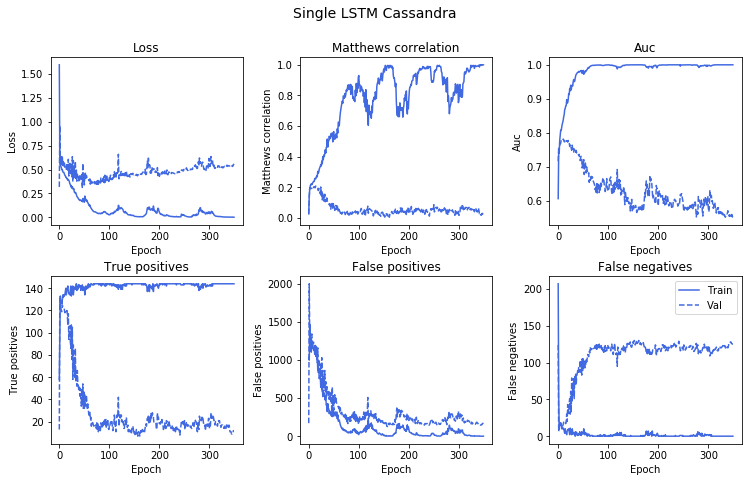

In [19]:
# plot learning curves
metric_names =  ['loss', 'matthews_correlation', 'auc', 'true_positives', 'false_positives', 'false_negatives']
filename = '../project_info/figures/single_LSTM_cassandra_learning_curves.png'
print(f"Total observations: {len(training_data)}")

plotting_functions.plot_metrics('Single LSTM Cassandra', history, metric_names, filename)

As expected, the training curves look pretty bad - the model is clearly over fit. But it does look like it was able to drive the loss to near zero.

In [20]:
# use trained model to make predictions from training, validation and testing data
train_predictions = model.predict(x_train, batch_size = batch_size)
validation_predictions = model.predict(x_validation, batch_size = batch_size)
test_predictions = model.predict(x_test, batch_size = batch_size)

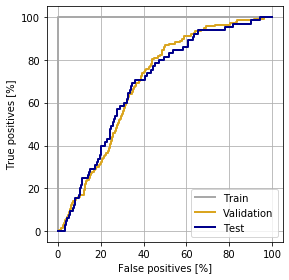

In [21]:
# plot ROC for all three datasets
plotting_functions.plot_roc("Train", y_train, train_predictions, color='darkgray')
plotting_functions.plot_roc("Validation", y_validation, validation_predictions, color='goldenrod')
plotting_functions.plot_roc("Test", y_test, test_predictions, color='darkblue')
plt.legend(loc='lower right')
plt.savefig('../project_info/figures/single_LSTM_cassandra_ROC.png', bbox_inches='tight')
plt.show()

Not surprisingly, the ROC curve also indicates extreme over fitting. The area under the training curve is almost 1, but is much less for the validation and test sets.

Now, for fun, let's take a look at some specific predictions and see what the actual output from the model looks like.

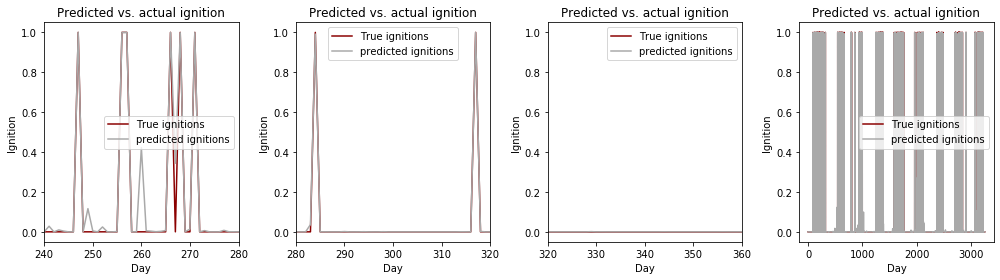

In [22]:
# plot training predictions vs actual ignitions
filename = '../project_info/figures/single_LSTM_cassandra_training_predictions.png'
plotting_functions.plot_ignition_predictions(train_predictions, y_train, filename)

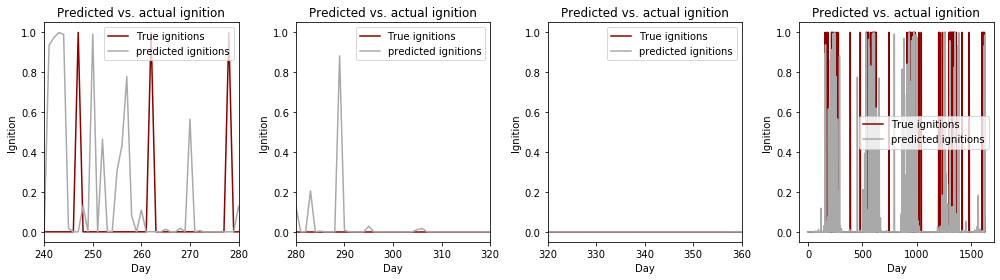

In [23]:
# plot test data predictions vs actual ignitions
filename = '../project_info/figures/single_LSTM_cassandra_test_predictions.png'
plotting_functions.plot_ignition_predictions(test_predictions, y_test, filename)

Last thing to take a look at are the confusion matrices for the training and test sets:


Training data prediction results
No fire (True Negatives):  3108
False alarms (False Positives):  0
Fires missed (False Negatives):  0
Fires detected (True Positives):  144
Total fires:  144

Test data prediction results
No fire (True Negatives):  1497
False alarms (False Positives):  64
Fires missed (False Negatives):  61
Fires detected (True Positives):  4
Total fires:  65


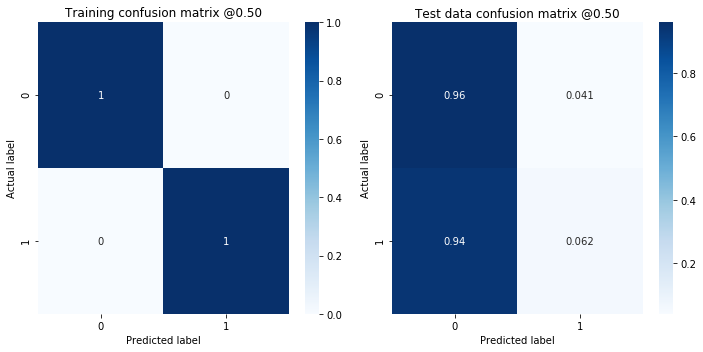

In [24]:
# results = model.evaluate(
#     x_train,
#     y_train,
#     batch_size = batch_size,
#     verbose=0
# )

# for name, value in zip(model.metrics_names, results):
#     print(name, ': ', value)
    
filename = '../project_info/figures/single_LSTM_cassandra_confusion_matrices.png'
plotting_functions.plot_cm(y_train, train_predictions, y_test, test_predictions, filename)

Results look great - despite the over fitting. Remember, over fitting was the goal. We have seen conclusively that their is enough information in the data and enough power in a LSTM to memorize the training set. This was not possible with gradient boosting decision trees or even deep neural networks. Now the task its to regularize the model so that it generalizes well.

# 3. LSTM optimization - regularize model & generalizability

Now that we know a LSTM can learn the training data, let's see how well we can get it to generalize to unseen test data. To do this we will run a second GPO round with the following changes:

1. Number of LSTM units will be added as a tunable parameter, and capped at 5 to reduce model complexity (this is also helpful for scaling the model)
2. Variational dropout will be added to the LSTM layer as a tunable parameter
3. Gaussian optimization and early stopping will use Matthews correlation on the validation set rather than the training set

At the same time, we will reoptimize the learning rate, class weights and past history, in case the optimum setting for those hyperparamters depend on the others.

### Set up gaussian process optimization

In [25]:
path_best_model = './trained_models/second_round_single_LSTM_optimization.keras'
best_val_matthews_correlation = -1.0

dim_learning_rate = Real(
    low=0.0001,
    high=0.1, 
    name='learning_rate'
)

dim_past_history = Integer(
    low=1,
    high=5, 
    name='past_history'
)

# dim_class_0_weight = Real(
#     low=0.001, 
#     high=10,
#     name='class_0_weight'
# )

# dim_class_1_weight = Real(
#     low=0.01, 
#     high=100,
#     name='class_1_weight'
# )

dim_lstm_units = Integer(
    low=1, 
    high=10,
    name='lstm_units'
)

dim_variational_dropout = Real(
    low=0.01, 
    high=0.5,
    name='variational_dropout'
)

default_parameters = [learning_rate, past_history, 1, 0.1]

dimensions = [
    dim_learning_rate,
    dim_past_history,
#     dim_class_0_weight,
#     dim_class_1_weight,
    dim_lstm_units,
    dim_variational_dropout
]

# Use early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_matthews_correlation', 
    patience = 10,
    mode = 'max',
    restore_best_weights = True
)


future_target = 1
step = 1
EPOCHS = 100

# also set initial value for output bias based on fire frequency
raw_output_bias = np.log([num_fires/(total_observations - num_fires)])
output_bias = tf.keras.initializers.Constant(raw_output_bias)

path_best_model = './trained_models/first_round_single_LSTM_optimization.keras'
best_matthews_correlation = -1.0

run_num = 1

In [26]:
def make_model(
        input_shape,
        learning_rate,
        lstm_units,
        variational_dropout,
):    
    
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.LSTM(
        lstm_units,
        batch_input_shape = input_shape,
        dropout = variational_dropout,
        stateful = True
    ))
    
    model.add(tf.keras.layers.Dense(
        1,
        activation = 'sigmoid',
        bias_initializer = output_bias)
    )

    model.compile(
        optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
        loss = keras.losses.BinaryCrossentropy(),
        metrics = metrics
    )

    return model

@use_named_args(dimensions=dimensions)
def fitness(
    learning_rate,
    past_history,
#     class_0_weight,
#     class_1_weight,
    lstm_units,
    variational_dropout
):
    # calculate batch and steps from past history size
    batch_size = int((len(training_data) * 0.99) // past_history)
    steps_per_epoch = int((len(training_data) * 0.99) // batch_size)
    validation_steps = int((len(validation_data) * 0.99) // batch_size)
    
    dataset_len = len(training_data)
    ignition_count = sum(training_data['ignition'])
    no_ignition_count = dataset_len - ignition_count
    
    weight_for_0 = (1 / no_ignition_count)*(dataset_len)/2.0 
    weight_for_1 = (1 / ignition_count)*(dataset_len)/2.0

    class_weight = {0: weight_for_0, 1: weight_for_1}
    
    # create data sets
    x_train, y_train = data_functions.multivariate_data(
        training_data,
        past_history,
        future_target, 
        step
    )
    
    x_validation, y_validation = data_functions.multivariate_data(
        validation_data,
        past_history,
        future_target, 
        step
    )
    
    # trim datasets so they are a whole number factor of the batch size
    start_index = (x_train.shape[0] - (x_train.shape[0] % batch_size))
    end_index = x_train.shape[0]
    
    x_train = np.delete(x_train, range(start_index, end_index), axis=0)
    y_train = np.delete(y_train, range(start_index, end_index), axis=0)
    
    start_index = (x_validation.shape[0] - (x_validation.shape[0] % batch_size))
    end_index = x_validation.shape[0]
    
    x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
    y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)
    
    input_dim = x_train.shape[-2:]
    input_shape = (batch_size, input_dim[0], input_dim[1])
    
    # Create the neural network with these hyper-parameters.
    model = make_model(
        input_shape = input_shape,
        learning_rate = learning_rate,
        lstm_units = lstm_units,
        variational_dropout = variational_dropout,
    )
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    global run_num
    
    log_dir = f'./LSTM_logs/single_statefull_gp_min_run{run_num}/'
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
   
    # Use Keras to train the model.
    history = model.fit(
        x_train,
        y_train,
        epochs = EPOCHS,
        batch_size = batch_size,
        steps_per_epoch = steps_per_epoch,
        callbacks = [early_stopping_callback],
        validation_data = (x_validation, y_validation),
        validation_steps = validation_steps,
        class_weight = class_weight,
        workers = 8,
        verbose = 0
    )

    # Get MCC for training run
    matthews_correlation = history.history['val_matthews_correlation'][-1]

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_matthews_correlation

    # If the MCC of the saved model is improved ...
    if matthews_correlation > best_matthews_correlation:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_matthews_correlation = matthews_correlation
        
    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    run_num += 1
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST MCC, we need to 
    # negate this number so it can be minimized.
    return -matthews_correlation

### Run gaussian process optimization

In [27]:
%%time

# do GPO
search_result = gp_minimize(
    func = fitness,
    dimensions = dimensions,
    acq_func = 'EI', # Expected Improvement.
    n_calls = 50,
    x0 = default_parameters
)

CPU times: user 8min 3s, sys: 22.9 s, total: 8min 26s
Wall time: 5min 12s


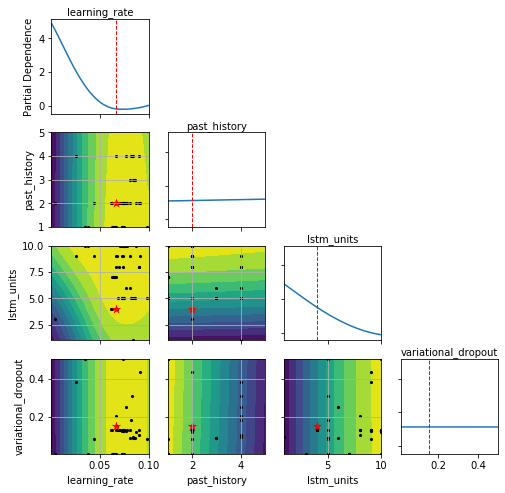

In [28]:
# extract winning hyperparameters
dim_names = [
    'learning_rate',
    'past_history',
#     'class_0_weight',
#     'class_1_weight',
    'lstm_units',
    'variational_dropout'
]

fig, ax = plot_objective(result = search_result, dimension_names = dim_names)
plt.savefig('../project_info/figures/single_LSTM_second_round_GPM.png', bbox_inches='tight')

### Re-train and evaluate winning model

In [29]:
space = search_result.space
winning_hyperparams = space.point_to_dict(search_result.x)
winning_hyperparams

{'learning_rate': 0.06659372913917586,
 'past_history': 2,
 'lstm_units': 4,
 'variational_dropout': 0.1541544489808192}

In [30]:
# hyperparameters
# learning_rate = winning_hyperparams['learning_rate']
# lstm_units = winning_hyperparams['lstm_units']

# learning_rate = 0.001
# past_history = 5
# class_0_weight = 6.3720941191248395
# class_1_weight = 94.18261239534365
# lstm_units = 1
# variational_dropout = 0.4

learning_rate = winning_hyperparams['learning_rate']
past_history = winning_hyperparams['past_history']
# class_0_weight = winning_hyperparams['class_0_weight']
# class_1_weight = winning_hyperparams['class_1_weight']
lstm_units = winning_hyperparams['lstm_units']
variational_dropout = winning_hyperparams['variational_dropout']

# class_weight = {0: class_0_weight, 1: class_1_weight}

EPOCHS = 500
batch_size = int((len(test_data) * 0.99) // past_history)
steps_per_epoch = int((len(training_data) * 0.99) // batch_size)
validation_steps = int((len(validation_data) * 0.99) // batch_size)

In [31]:
print(f'Past history {past_history}')
print(f'Batch size: {batch_size}')
print(f'Steps per epoch: {steps_per_epoch}')

Past history 2
Batch size: 1084
Steps per epoch: 3


In [32]:
x_train, y_train = data_functions.multivariate_data(
    training_data,
    past_history,
    future_target, 
    step
)

start_index = (x_train.shape[0] - (x_train.shape[0] % batch_size))
end_index = x_train.shape[0]
x_train = np.delete(x_train, range(start_index, end_index), axis=0)
y_train = np.delete(y_train, range(start_index, end_index), axis=0)

x_validation, y_validation = data_functions.multivariate_data(
    validation_data,
    past_history,
    future_target, 
    step
)

start_index = (x_validation.shape[0] - (x_validation.shape[0] % batch_size))
end_index = x_validation.shape[0]
x_validation = np.delete(x_validation, range(start_index, end_index), axis=0)
y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)

x_test, y_test = data_functions.multivariate_data(
    test_data,
    past_history,
    future_target, 
    step
)

start_index = (x_test.shape[0] - (x_test.shape[0] % batch_size))
end_index = x_test.shape[0]
x_testing = np.delete(x_test, range(start_index, end_index), axis=0)
y_testing = np.delete(y_test, range(start_index, end_index), axis=0)

input_dim = x_testing.shape[-2:]
input_shape = (batch_size, input_dim[0], input_dim[1])

In [33]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(
    lstm_units,
    batch_input_shape = input_shape,
    dropout = variational_dropout,
    stateful = True
))

model.add(tf.keras.layers.Dense(
    1,
    activation = 'sigmoid',
    bias_initializer = output_bias)
)

model.compile(
    optimizer = tf.keras.optimizers.Adam(lr = learning_rate), 
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = metrics
)

In [34]:
%%time

history = model.fit(
    x_train,
    y_train,
    epochs = EPOCHS,
    batch_size = batch_size,
    steps_per_epoch = steps_per_epoch,
    #callbacks = [early_stopping_callback],
    validation_data = (x_validation, y_validation),
    validation_steps = validation_steps,
    class_weight = class_weight,
    workers = 8,
    verbose = 0
)

CPU times: user 1min 2s, sys: 5.72 s, total: 1min 8s
Wall time: 39.4 s


Total observations: 3287


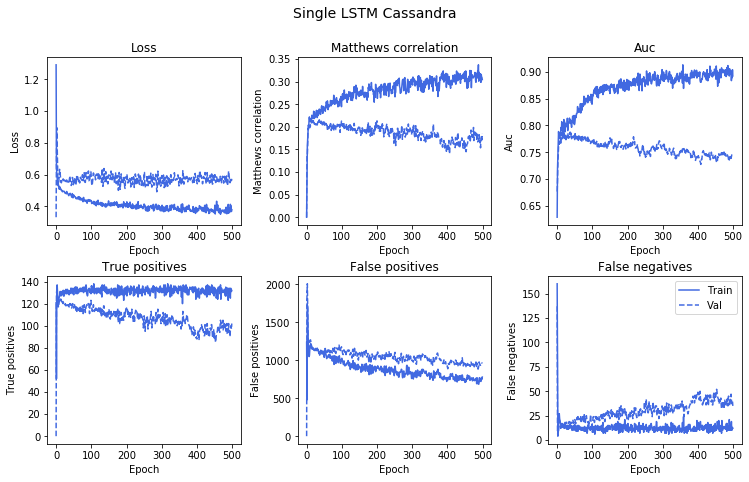

In [35]:
# plot learning curves
metric_names =  ['loss', 'matthews_correlation', 'auc', 'true_positives', 'false_positives', 'false_negatives']
filename = '../project_info/figures/single_LSTM_optimized_learning_curves.png'
print(f"Total observations: {len(training_data)}")

plotting_functions.plot_metrics('Single LSTM Cassandra', history, metric_names, filename)

In [36]:
train_predictions = model.predict(x_train, batch_size = batch_size)
validation_predictions = model.predict(x_validation, batch_size = batch_size)
test_predictions = model.predict(x_testing, batch_size = batch_size)

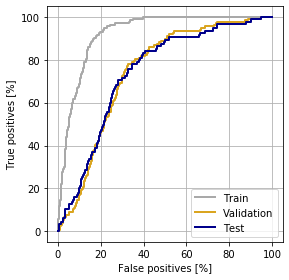

In [37]:
plotting_functions.plot_roc("Train", y_train, train_predictions, color='darkgray')
plotting_functions.plot_roc("Validation", y_validation, validation_predictions, color='goldenrod')
plotting_functions.plot_roc("Test", y_testing, test_predictions, color='darkblue')
plt.legend(loc='lower right')
plt.show()

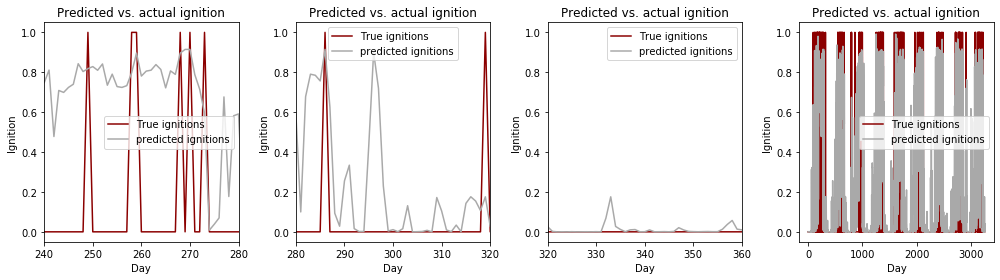

In [38]:
filename = '../project_info/figures/single_LSTM_optimized_training_predictions.png'
plotting_functions.plot_ignition_predictions(train_predictions, y_train, filename)

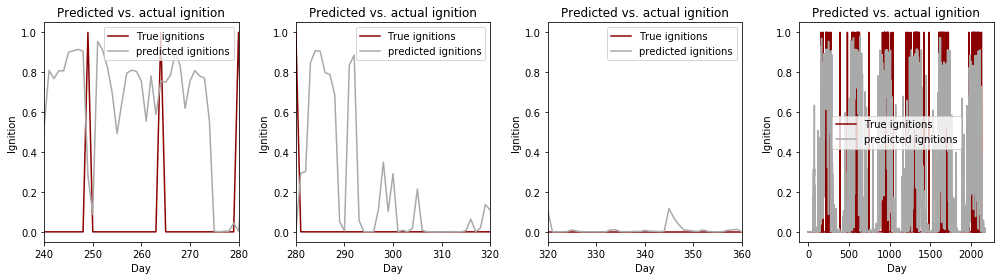

In [39]:
filename = '../project_info/figures/single_LSTM_optimized_testing_predictions.png'
plotting_functions.plot_ignition_predictions(test_predictions, y_testing, filename)


Training data prediction results
No fire (True Negatives):  2297
False alarms (False Positives):  811
Fires missed (False Negatives):  5
Fires detected (True Positives):  139
Total fires:  144

Test data prediction results
No fire (True Negatives):  1436
False alarms (False Positives):  637
Fires missed (False Negatives):  27
Fires detected (True Positives):  68
Total fires:  95


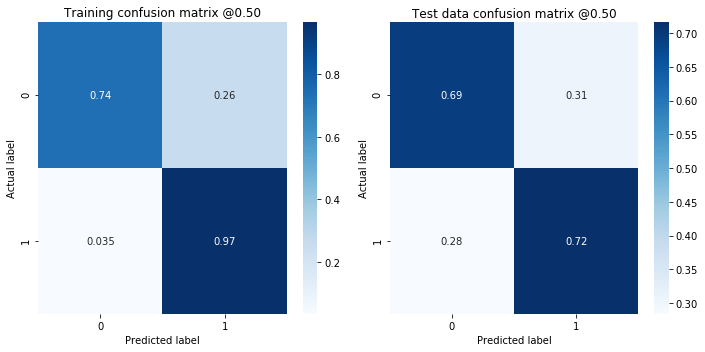

In [40]:
# results = model.evaluate(
#     x_train,
#     y_train, 
#     verbose=0
# )

# for name, value in zip(model.metrics_names, results):
#     print(name, ': ', value)
    
filename = '../project_info/figures/single_LSTM_optimizedweather_confusion_matrices.png'
plotting_functions.plot_cm(y_train, train_predictions, y_testing, test_predictions, filename)